# Import Libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.cm as cm

from wordcloud import WordCloud

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sentence_transformers import SentenceTransformer

# Data Loading

In [2]:
df = pd.read_json('yugioh_cards.json')

# Exploratory Data Analysis

In [3]:
df.head(5)

,id,name,type,humanReadableCardType,frameType,desc,race,archetype,ygoprodeck_url,card_sets,...,atk,def,level,attribute,linkval,linkmarkers,pend_desc,monster_desc,scale,banlist_info
0,34541863,"""A"" Cell Breeding Device",Spell Card,Continuous Spell,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,https://ygoprodeck.com/card/a-cell-breeding-de...,"[{'set_name': 'Force of the Breaker', 'set_cod...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,Continuous Spell,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,https://ygoprodeck.com/card/a-cell-incubator-8856,"[{'set_name': 'Gladiator's Assault', 'set_code...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,Quick-Play Spell,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,https://ygoprodeck.com/card/a-cell-recombinati...,"[{'set_name': 'Invasion: Vengeance', 'set_code...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73262676,"""A"" Cell Scatter Burst",Spell Card,Quick-Play Spell,spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play,Alien,https://ygoprodeck.com/card/a-cell-scatter-bur...,"[{'set_name': 'Strike of Neos', 'set_code': 'S...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98319530,"""Infernoble Arms - Almace""",Spell Card,Equip Spell,spell,While this card is equipped to a monster: You ...,Equip,Infernoble Arms,https://ygoprodeck.com/card/infernoble-arms-al...,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13567 non-null  int64  
 1   name                   13567 non-null  object 
 2   type                   13567 non-null  object 
 3   humanReadableCardType  13567 non-null  object 
 4   frameType              13567 non-null  object 
 5   desc                   13567 non-null  object 
 6   race                   13567 non-null  object 
 7   archetype              8043 non-null   object 
 8   ygoprodeck_url         13567 non-null  object 
 9   card_sets              13097 non-null  object 
 10  card_images            13567 non-null  object 
 11  card_prices            13567 non-null  object 
 12  typeline               8712 non-null   object 
 13  atk                    8712 non-null   float64
 14  def                    8286 non-null   float64
 15  le

In [5]:
df2 = df[['id','name','frameType','desc','race']]

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13567 non-null  int64 
 1   name       13567 non-null  object
 2   frameType  13567 non-null  object
 3   desc       13567 non-null  object
 4   race       13567 non-null  object
dtypes: int64(1), object(4)
memory usage: 530.1+ KB


In [7]:
df2.head()

,id,name,frameType,desc,race
0,34541863,"""A"" Cell Breeding Device",spell,"During each of your Standby Phases, put 1 A-Co...",Continuous
1,64163367,"""A"" Cell Incubator",spell,Each time an A-Counter(s) is removed from play...,Continuous
2,91231901,"""A"" Cell Recombination Device",spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play
3,73262676,"""A"" Cell Scatter Burst",spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play
4,98319530,"""Infernoble Arms - Almace""",spell,While this card is equipped to a monster: You ...,Equip


In [8]:
df2 = df2.iloc[:, [0,1,2,4,3]]

In [9]:
df2.head()

,id,name,frameType,race,desc
0,34541863,"""A"" Cell Breeding Device",spell,Continuous,"During each of your Standby Phases, put 1 A-Co..."
1,64163367,"""A"" Cell Incubator",spell,Continuous,Each time an A-Counter(s) is removed from play...
2,91231901,"""A"" Cell Recombination Device",spell,Quick-Play,Target 1 face-up monster on the field; send 1 ...
3,73262676,"""A"" Cell Scatter Burst",spell,Quick-Play,"Select 1 face-up ""Alien"" monster you control. ..."
4,98319530,"""Infernoble Arms - Almace""",spell,Equip,While this card is equipped to a monster: You ...


In [10]:
df2.isna().sum()

id           0
name         0
frameType    0
race         0
desc         0
dtype: int64

In [11]:
df2.drop_duplicates()

,id,name,frameType,race,desc
0,34541863,"""A"" Cell Breeding Device",spell,Continuous,"During each of your Standby Phases, put 1 A-Co..."
1,64163367,"""A"" Cell Incubator",spell,Continuous,Each time an A-Counter(s) is removed from play...
2,91231901,"""A"" Cell Recombination Device",spell,Quick-Play,Target 1 face-up monster on the field; send 1 ...
3,73262676,"""A"" Cell Scatter Burst",spell,Quick-Play,"Select 1 face-up ""Alien"" monster you control. ..."
4,98319530,"""Infernoble Arms - Almace""",spell,Equip,While this card is equipped to a monster: You ...
...,...,...,...,...,...
13562,2648201,ZW - Sleipnir Mail,effect,Beast,"You can target 1 ""Utopia"" monster you control;..."
13563,95886782,ZW - Sylphid Wing,effect,Beast,"You can only control 1 ""ZW - Sylphid Wing"". Yo..."
13564,81471108,ZW - Tornado Bringer,effect,Dragon,"You can target 1 ""Utopia"" monster you control;..."
13565,18865703,ZW - Ultimate Shield,effect,Aqua,When this card is Normal or Special Summoned: ...


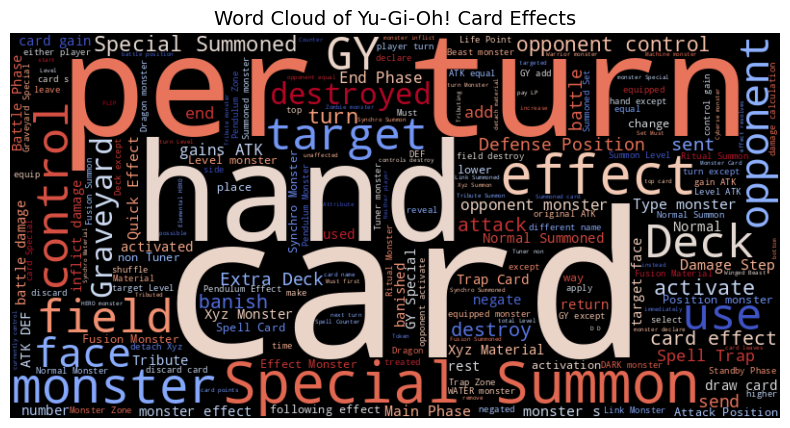

In [12]:
text_data = " ".join(df2['desc'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm',
                      max_words=200, contour_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Yu-Gi-Oh! Card Effects", fontsize=14)
plt.show()

In [13]:
# Aggregate count of each frameType
frame_counts = df2['frameType'].value_counts().reset_index()
frame_counts.columns = ['frameType', 'count']  # Rename columns for clarity

# Create Pie Chart
fig = px.pie(
    frame_counts,  
    names='frameType',  # Categories
    values='count',  # Use the counts for the segment sizes
    title='Distribution of Frame Types'
)

fig.show()

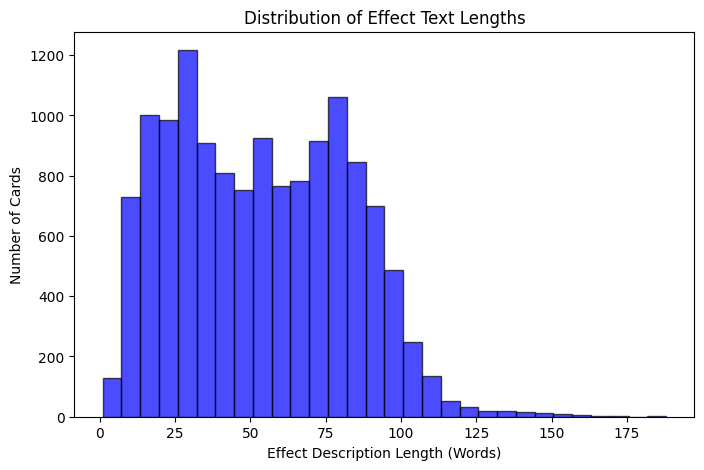

In [14]:
df2["desc_length"] = df2["desc"].apply(lambda x: len(str(x).split()))

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(df2["desc_length"], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Effect Description Length (Words)")
plt.ylabel("Number of Cards")
plt.title("Distribution of Effect Text Lengths")
plt.show()

# Feature Engineering

In [15]:
df2 = df2[df2['frameType']!='normal'].reset_index(drop=True)

Since the normal monster always part of the core deck, they also don't have effects I don't think they need to be categorized.

In [16]:
custom_stopwords = set([
    "your", "controls", "control", "use", "position", "activated", 
    "from", "the", "to", "is", "that", "includes", "any", "these", 
    "you", "can", "this", "for", "of", "during", "phase", "except", "either", "player", 
    "once", "only", "until", "end"
])

In [17]:
# # Function to clean text and remove stopwords
# def Clean_RemoveStopword(text, stopwords_set):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove special characters and punctuation
#     text = re.sub(r'\W+', ' ', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Remove stopwords
#     text = " ".join([word for word in text.split() if word not in stopwords_set])
#     return text

In [18]:
def refine_card_description(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    words = text.split()
    
    # Remove stopwords but keep game-related words
    filtered_text = " ".join([word for word in words if word not in custom_stopwords])
    
    return filtered_text

In [19]:
# Apply the improved function to the dataset
df2['refined_desc'] = df2['desc'].apply(refine_card_description)

## Making Tokens by Splitting it using Space

In [20]:
df2['tokens'] = df2['refined_desc'].apply(lambda x: x.split())

In [21]:
df2[['tokens','refined_desc']].head()

,tokens,refined_desc
0,"[each, standby, phases, put, 1, acounter, on, ...",each standby phases put 1 acounter on 1 faceup...
1,"[each, time, an, acounters, removed, play, by,...",each time an acounters removed play by a card ...
2,"[target, 1, faceup, monster, on, field, send, ...",target 1 faceup monster on field send 1 alien ...
3,"[select, 1, faceup, alien, monster, destroy, i...",select 1 faceup alien monster destroy it and d...
4,"[while, card, equipped, a, monster, equip, 1, ...",while card equipped a monster equip 1 infernob...


# Model Creation

## TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['refined_desc'])  # Use refined descriptions

# Convert to NumPy array
tfidf_features = tfidf_matrix.toarray()

## SBERT

In [23]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert card descriptions into embeddings
sentence_embeddings = sbert_model.encode(df2['refined_desc'], show_progress_bar=True)

# Convert embeddings to a NumPy array
sentence_embeddings = np.array(sentence_embeddings)

# Check embedding shape
print(sentence_embeddings.shape)


Batches:   0%|          | 0/403 [00:00<?, ?it/s]

(12890, 384)


In [24]:
from sklearn.preprocessing import normalize
sbert_embeddings = normalize(sentence_embeddings)

# Normalize TF-IDF features
tfidf_features = normalize(tfidf_features)

# Concatenate both SBERT and TF-IDF features
combined_features = np.hstack((sbert_embeddings, tfidf_features))

## Use KMeans

In [25]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=26, n_init=10)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

df2["cluster"] = cluster_labels

df2["cluster"].value_counts()

cluster
4    2726
6    2454
1    2309
3    1861
0    1679
5    1395
2     466
Name: count, dtype: int64

## Cosine Similarity

In [26]:
# Compute cosine similarity between cards and cluster centroids
cluster_centroids = kmeans.cluster_centers_
similarities = cosine_similarity(sentence_embeddings, cluster_centroids)

# Set a threshold (e.g., 0.5) for multi-label assignment
threshold = 0.61
multi_labels = [[i for i, sim in enumerate(sim) if sim > threshold] for sim in similarities]

# Store multi-labels in the dataframe
df2['multi_labels'] = multi_labels

In [27]:
df2[df2['name']=='Ash Blossom & Joyous Spring']

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
698,14558127,Ash Blossom & Joyous Spring,effect,Zombie,When a card or effect is activated that includ...,64,when a card or effect effects quick effect dis...,"[when, a, card, or, effect, effects, quick, ef...",4,"[0, 4, 6]"


In [28]:
df2[df2['name']=='Effect Veiler']

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
3426,97268402,Effect Veiler,effect,Spellcaster,During your opponent's Main Phase (Quick Effec...,42,opponents main quick effect send card hand gy ...,"[opponents, main, quick, effect, send, card, h...",1,"[0, 1, 4]"


In [29]:
df2[df2['name']=='Lava Golem']

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
6246,102380,Lava Golem,effect,Fiend,Cannot be Normal Summoned/Set. Must first be S...,43,cannot be normal summonedset must first be spe...,"[cannot, be, normal, summonedset, must, first,...",6,"[3, 4, 6]"


In [30]:
df2[df2['name']=='The Winged Dragon of Ra - Sphere Mode']

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
11378,10000080,The Winged Dragon of Ra - Sphere Mode,effect,Divine-Beast,Cannot be Special Summoned. Requires 3 Tribute...,85,cannot be special summoned requires 3 tributes...,"[cannot, be, special, summoned, requires, 3, t...",6,"[4, 6]"


In [31]:
df2[df2['name']=='Thunder King, the Lightningstrike Kaiju']

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
11444,48770333,"Thunder King, the Lightningstrike Kaiju",effect,Thunder,You can Special Summon this card (from your ha...,96,special summon card hand opponents side field ...,"[special, summon, card, hand, opponents, side,...",1,"[0, 1, 3, 4, 6]"


In [53]:
df2[df2['name'] == "Raigeki"][['name', 'refined_desc', 'cluster']]

,name,refined_desc,cluster
9014,Raigeki,destroy all monsters opponent,4


In [54]:
df2[df2['name']=="Lightning Storm"][['name', 'refined_desc', 'cluster']]

,name,refined_desc,cluster
6389,Lightning Storm,if no faceup cards activate 1 effects destroy ...,4


In [55]:
df2[df2['name']=="Harpie's Feather Duster"][['name', 'refined_desc', 'cluster']]

,name,refined_desc,cluster
5249,Harpie's Feather Duster,destroy all spell and trap cards opponent,0


In [59]:
combined_df = df2.query("name in ['Raigeki', 'Lightning Storm', \"Harpie's Feather Duster\"]")[['name', 'refined_desc', 'cluster']]
combined_df

,name,refined_desc,cluster
5249,Harpie's Feather Duster,destroy all spell and trap cards opponent,0
6389,Lightning Storm,if no faceup cards activate 1 effects destroy ...,4
9014,Raigeki,destroy all monsters opponent,4


In [35]:
df2[df2['name']=="Reinforcement of the Army"]

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
9222,32807846,Reinforcement of the Army,spell,Normal,Add 1 Level 4 or lower Warrior monster from yo...,14,add 1 level 4 or lower warrior monster deck hand,"[add, 1, level, 4, or, lower, warrior, monster...",3,[]


In [36]:
df2[df2['name']=="Shien's Smoke Signal"]

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels
9932,54031490,Shien's Smoke Signal,spell,Normal,"Add 1 Level 3 or lower ""Six Samurai"" monster f...",15,add 1 level 3 or lower six samurai monster dec...,"[add, 1, level, 3, or, lower, six, samurai, mo...",3,[]


In [37]:
raigeki_emb = sentence_embeddings[df2[df2['name'] == 'Raigeki'].index[0]].reshape(1, -1)
storm_emb = sentence_embeddings[df2[df2['name'] == 'Lightning Storm'].index[0]].reshape(1, -1)
harpie_emb = sentence_embeddings[df2[df2['name'] == "Harpie's Feather Duster"].index[0]].reshape(1, -1)

similarity_raigeki_harpie = cosine_similarity(raigeki_emb, harpie_emb)[0][0]
similarity_storm_harpie = cosine_similarity(storm_emb, harpie_emb)[0][0]

print(f"Cosine Similarity (Raigeki <-> Harpie's Feather Duster): {similarity_raigeki_harpie}")
print(f"Cosine Similarity (Lightning Storm <-> Harpie's Feather Duster): {similarity_storm_harpie}")

Cosine Similarity (Raigeki <-> Harpie's Feather Duster): 0.5945907831192017
Cosine Similarity (Lightning Storm <-> Harpie's Feather Duster): 0.5258975028991699


In [38]:
sil_score = silhouette_score(sentence_embeddings, df2['cluster'])
db_score = davies_bouldin_score(sentence_embeddings, df2['cluster'])

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {db_score}")

Silhouette Score: 0.03474004194140434
Davies-Bouldin Index: 4.033731903002662


## Semi-Unsupervised

In [39]:
# Define known labels
known_labels = {
    "Raigeki": "board-breaker",
    "Harpie's Feather Duster": "board-breaker",
    "Lightning Storm": "board-breaker",
    
    "Ash Blossom & Joyous Spring": "hand-traps",
    "Effect Veiler": "hand-traps",
    "Droll & Lock Bird": "hand-traps",
    
    "Reinforcement of the Army": "searcher",
    "Shien's Smoke Signal": "searcher",
}

# Initialize a column for categories
df2['category'] = df2['name'].map(known_labels).fillna("unknown")  # Assign known categories, others remain 'unknown'


In [40]:
# Set number of clusters (adjust based on expected groups)
num_clusters = 7  # Since you identified 7 categories

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=26)
df2['cluster'] = kmeans.fit_predict(sentence_embeddings)

In [41]:
# Group by cluster to see which cards ended up together
df2.groupby("cluster")['name'].apply(list)

cluster
0    ["Infernoble Arms - Durendal", "Infernoble Arm...
1    [1st Movement Solo, A Hero Emerges, A Rival Ap...
2    [7 Completed, A Legendary Ocean, A Shattered, ...
3    [3-Hump Lacooda, 7, A Cat of Ill Omen, A Feath...
4    ["A" Cell Breeding Device, "A" Cell Incubator,...
5    ["A" Cell Recombination Device, A Deal with Da...
6    [Abyss Actor - Comic Relief, Abyss Actor - Cur...
Name: name, dtype: object

In [42]:
# Create a mapping for cluster IDs → categories
cluster_names = {
    df2[df2['category'] == "board-breaker"]['cluster'].mode()[0]: "board-breaker",
    df2[df2['category'] == "hand-traps"]['cluster'].mode()[0]: "hand-traps",
    df2[df2['category'] == "searcher"]['cluster'].mode()[0]: "searcher",
}

# Assign final category names
df2['final_category'] = df2['cluster'].map(cluster_names).fillna("unknown")

In [43]:
df2[['name', 'refined_desc', 'final_category']]

,name,refined_desc,final_category
0,"""A"" Cell Breeding Device",each standby phases put 1 acounter on 1 faceup...,board-breaker
1,"""A"" Cell Incubator",each time an acounters removed play by a card ...,board-breaker
2,"""A"" Cell Recombination Device",target 1 faceup monster on field send 1 alien ...,unknown
3,"""A"" Cell Scatter Burst",select 1 faceup alien monster destroy it and d...,board-breaker
4,"""Infernoble Arms - Almace""",while card equipped a monster equip 1 infernob...,board-breaker
...,...,...,...
12885,ZW - Sleipnir Mail,target 1 utopia monster equip monster hand or ...,unknown
12886,ZW - Sylphid Wing,1 zw sylphid wing target 1 utopia monster equi...,unknown
12887,ZW - Tornado Bringer,target 1 utopia monster equip monster hand or ...,unknown
12888,ZW - Ultimate Shield,when card normal or special summoned target 1 ...,unknown


## A bit Manual

In [44]:
# Compute pairwise cosine similarity for all SBERT embeddings
cosine_sim_matrix = cosine_similarity(sentence_embeddings)

# Convert to DataFrame for readability
sim_df = pd.DataFrame(cosine_sim_matrix, index=df2['name'], columns=df2['name'])

# Show similarity between some cards
sim_df.loc[['Raigeki', 'Harpie\'s Feather Duster', 'Lightning Storm'], 
           ['Raigeki', 'Harpie\'s Feather Duster', 'Lightning Storm']]

name,Raigeki,Harpie's Feather Duster,Lightning Storm
name,,,
Raigeki,1.000000,0.594591,0.452152
Harpie's Feather Duster,0.594591,1.000000,0.525897
Lightning Storm,0.452152,0.525897,1.000000


In [45]:
sim_df.loc[['Reinforcement of the Army', 'Shien\'s Smoke Signal', 'Heritage of the Chalice'], 
           ['Reinforcement of the Army', 'Shien\'s Smoke Signal', 'Heritage of the Chalice']]

name,Reinforcement of the Army,Shien's Smoke Signal,Heritage of the Chalice
name,,,
Reinforcement of the Army,1.000000,0.826812,0.504561
Shien's Smoke Signal,0.826812,1.000000,0.430619
Heritage of the Chalice,0.504561,0.430619,1.000000


In [46]:
# Define a similarity threshold (adjust based on results)
SIMILARITY_THRESHOLD = 0.55

# Create an empty dictionary to store card clusters
card_clusters = {}

# Loop through each card and find its most similar cards
for card in df2['name']:
    similar_cards = sim_df[card][sim_df[card] >= SIMILARITY_THRESHOLD].index.tolist()
    card_clusters[card] = ', '.join(similar_cards)  # Convert list to a string

# Convert dictionary to DataFrame
card_cluster_df = pd.DataFrame(list(card_clusters.items()), columns=['Card', 'Similar Cards'])

# Display the result
card_cluster_df.head()


,Card,Similar Cards
0,"""A"" Cell Breeding Device","""A"" Cell Breeding Device, ""A"" Cell Incubator, ..."
1,"""A"" Cell Incubator","""A"" Cell Breeding Device, ""A"" Cell Incubator, ..."
2,"""A"" Cell Recombination Device","""A"" Cell Incubator, ""A"" Cell Recombination Dev..."
3,"""A"" Cell Scatter Burst","""A"" Cell Breeding Device, ""A"" Cell Incubator, ..."
4,"""Infernoble Arms - Almace""","""Infernoble Arms - Almace"", ""Infernoble Arms -..."


In [47]:
card_name = "Effect Veiler"

# Check which cards were grouped with it
if card_name in card_clusters:
    print(f"Cards similar to {card_name}:")
    print(card_clusters[card_name])
else:
    print(f"{card_name} not found in clusters.")


Cards similar to Effect Veiler:
"Infernoble Arms - Hauteclere", "Infernoble Arms - Joyeuse", A Bao A Qu, the Lightless Shadow, A-Assault Core, A-Team: Trap Disposal Unit, A.I. Shadow, A.I.dle Reborn, Abduction, Absolute End, Absolute King Back Jack, Abyss Actor - Evil Heel, Abyss Actor - Superstar, Abyss Script - Fantasy Magic, Accesscode Talker, Action Magic - Double Banking, Advanced Crystal Beast Amber Mammoth, Advanced Crystal Beast Amethyst Cat, Advanced Crystal Beast Cobalt Eagle, Advanced Crystal Beast Emerald Tortoise, Aeropixthree, Ages of Stars and Frost, Air Cracking Storm, Airorca, Aiwass, the Magistus Spell Spirit, Alector, Sovereign of Birds, Aleister the Invoker, Alich, Malebranche of the Burning Abyss, Alien Hypno, Alien Stealthbuster, All-Out Attacks, Ally of Justice Enemy Catcher, Ally of Justice Reverse Break, Ally of Justice Searcher, Altergeist Adminia, Altergeist Camouflage, Altergeist Failover, Altergeist Haunted Rock, Altergeist Kunquery, Altergeist Malwisp, Alt

In [48]:
ash_emb = sentence_embeddings[df2[df2['name'] == 'Ash Blossom & Joyous Spring'].index[0]].reshape(1, -1)
veiler_emb = sentence_embeddings[df2[df2['name'] == 'Effect Veiler'].index[0]].reshape(1, -1)
droll_emb = sentence_embeddings[df2[df2['name'] == 'Droll & Lock Bird'].index[0]].reshape(1, -1)

similarity_ash_veiler = cosine_similarity(ash_emb, veiler_emb)[0][0]
similarity_ash_droll = cosine_similarity(ash_emb, droll_emb)[0][0]
similarity_veiler_droll = cosine_similarity(veiler_emb, droll_emb)[0][0]

print(f"Cosine Similarity (Ash Blossom <-> Effect Veiler): {similarity_ash_veiler:.4f}")
print(f"Cosine Similarity (Ash Blossom <-> Droll & Lock Bird): {similarity_ash_droll:.4f}")
print(f"Cosine Similarity (Effect Veiler <-> Droll & Lock Bird): {similarity_veiler_droll:.4f}")

Cosine Similarity (Ash Blossom <-> Effect Veiler): 0.5387
Cosine Similarity (Ash Blossom <-> Droll & Lock Bird): 0.5966
Cosine Similarity (Effect Veiler <-> Droll & Lock Bird): 0.5656


In [49]:
for card in ['Ash Blossom & Joyous Spring', 'Effect Veiler', 'Droll & Lock Bird']:
    print(f"{card}: {df2[df2['name'] == card]['refined_desc'].values[0]}")

Ash Blossom & Joyous Spring: when a card or effect effects quick effect discard card negate effect add a card deck hand special summon deck send a card deck gy effect ash blossom joyous spring per turn
Effect Veiler: opponents main quick effect send card hand gy then target 1 effect monster opponent negate effects faceup monster opponent turn
Droll & Lock Bird: if a cards added main deck opponents hand draw quick effect send card hand gy rest turn cards cannot be added players main deck hand


In [50]:
# Define known hand-traps
hand_traps = ["Effect Veiler", "Ash Blossom & Joyous Spring", "Droll & Lock Bird"]

# Assign known cluster label (e.g., 0 = hand-trap)
df2['forced_cluster'] = -1
df2.loc[df2['name'].isin(hand_traps), 'forced_cluster'] = 0  # Assign hand-trap cluster

# Re-run clustering, but force known cards to stay together
num_clusters = 7  # Adjust based on total categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df2['cluster'] = kmeans.fit_predict(sentence_embeddings)

# Override clusters for known hand-traps
df2.loc[df2['forced_cluster'] == 0, 'cluster'] = 0

# Cluster Check

## Cluster 0

In [51]:
df2[df2['cluster']== 0].head()

,id,name,frameType,race,desc,desc_length,refined_desc,tokens,cluster,multi_labels,category,final_category,forced_cluster
2,91231901,"""A"" Cell Recombination Device",spell,Quick-Play,Target 1 face-up monster on the field; send 1 ...,66,target 1 faceup monster on field send 1 alien ...,"[target, 1, faceup, monster, on, field, send, ...",0,"[0, 1, 3, 4, 5]",unknown,unknown,-1
9,86988864,3-Hump Lacooda,effect,Beast,"If there are 3 face-up ""3-Hump Lacooda"" cards ...",22,if there are 3 faceup 3hump lacooda cards on s...,"[if, there, are, 3, faceup, 3hump, lacooda, ca...",0,[0],unknown,hand-traps,-1
11,67048711,7,spell,Continuous,"When there are 3 face-up ""7"" cards on your sid...",43,when there are 3 faceup 7 cards on side field ...,"[when, there, are, 3, faceup, 7, cards, on, si...",0,[0],unknown,hand-traps,-1
15,24140059,A Cat of Ill Omen,effect,Beast,FLIP: Choose 1 Trap from your Deck and place i...,31,flip choose 1 trap deck and place it on top de...,"[flip, choose, 1, trap, deck, and, place, it, ...",0,[0],unknown,hand-traps,-1
17,49140998,A Feather of the Phoenix,spell,Normal,"Discard 1 card, then target 1 card in your GY;...",19,discard 1 card then target 1 card in gy return...,"[discard, 1, card, then, target, 1, card, in, ...",0,[],unknown,hand-traps,-1


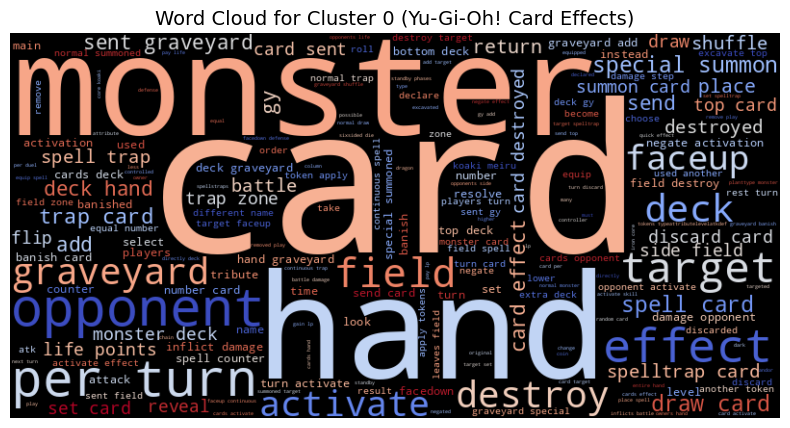

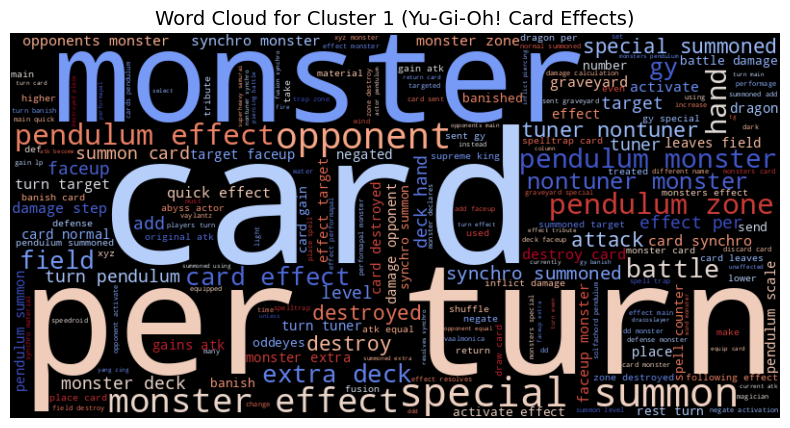

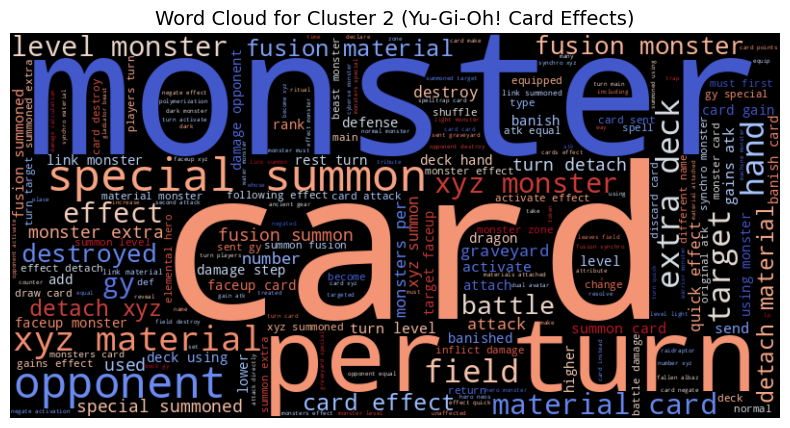

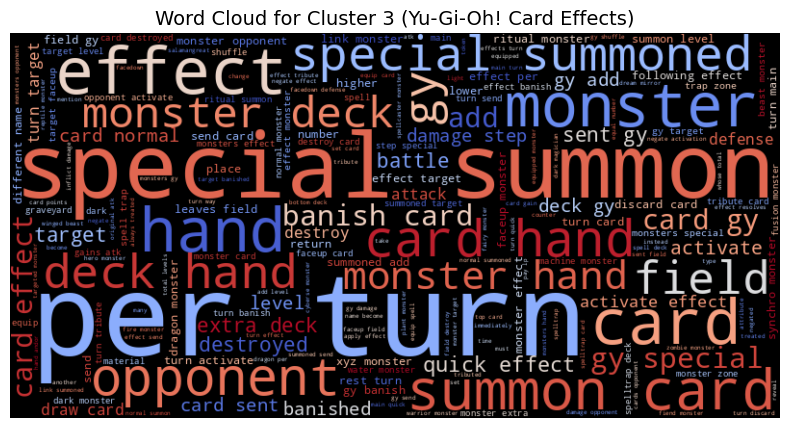

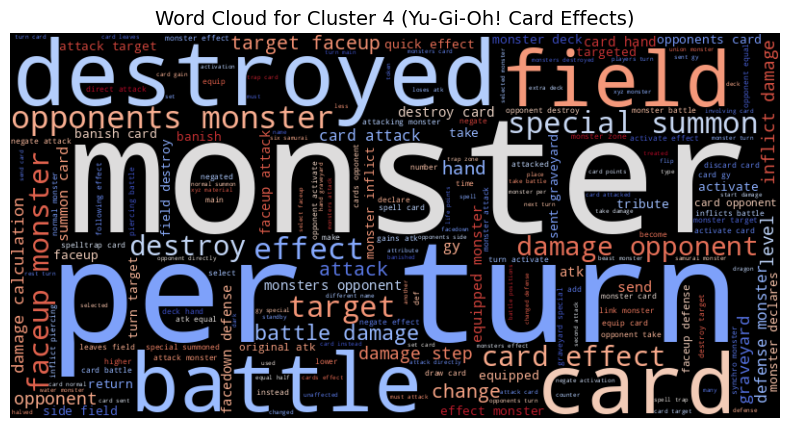

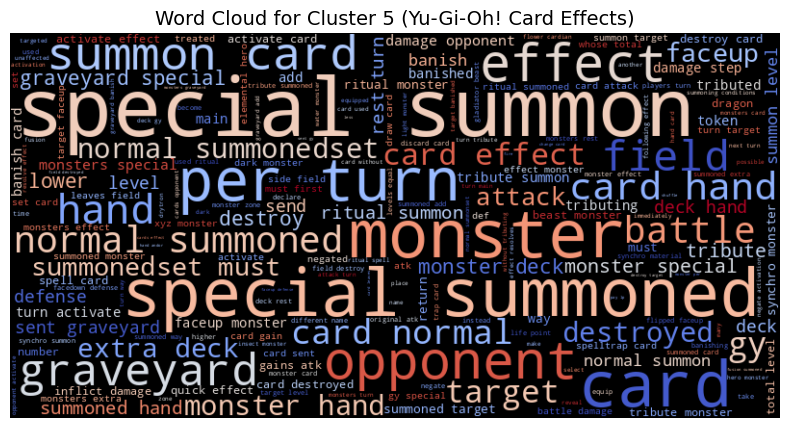

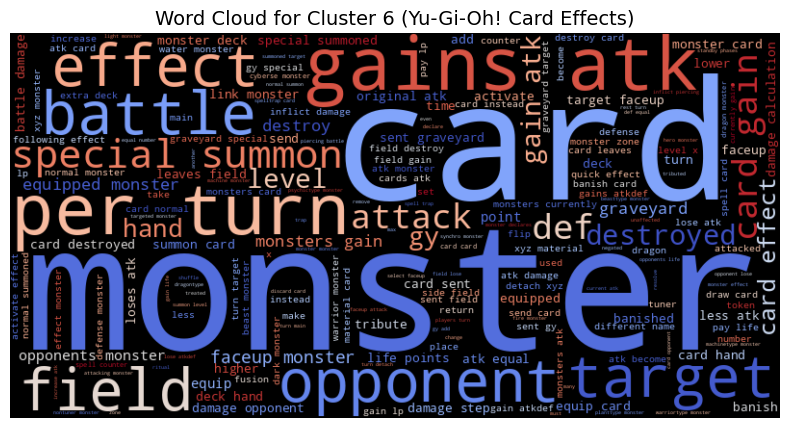

In [52]:
# Filter data for Cluster 0

for i in range(0,7):
    cluster_text = " ".join(df2[df2['cluster'] == i]['refined_desc'])
    # Generate word cloud for Cluster 0
    wordcloud = WordCloud(
        width=800, height=400, background_color='black', colormap='coolwarm',
        max_words=200, contour_color='white'
    ).generate(cluster_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title(f"Word Cloud for Cluster {i} (Yu-Gi-Oh! Card Effects)", fontsize=14)
    plt.show()